In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [2]:
DATA_DIR = "/home/n.anokhin/data/msd/"

In [3]:
# http://millionsongdataset.com/tasteprofile/#getting
raw_data = pd.read_csv(DATA_DIR + "train_triplets.txt", sep="\t", names=["user_id", "song_id", "play_count"])
# http://millionsongdataset.com/sites/default/files/AdditionalFiles/unique_tracks.txt
meta = pd.read_csv(DATA_DIR + "unique_tracks.txt", sep="<SEP>", engine="python", names=["track_id", "song_id", "artist", "title"])

In [4]:
top_songs = raw_data["song_id"].value_counts()[:50000]
top_songs_data = raw_data[raw_data["song_id"].isin(top_songs.index)].copy()

In [5]:
user_song_counts = top_songs_data["user_id"].value_counts()
top_users = user_song_counts[user_song_counts >= 5]

In [6]:
data = top_songs_data[top_songs_data["user_id"].isin(top_users.index)].copy()
data["test"] = np.random.random(len(data)) < 0.2

In [7]:
dataset = ld.Dataset()
dataset.fit(data["user_id"], data["song_id"])

## Prepare tracks catalog for the recommender

In [8]:
item_index = [song_id for song_id, index in sorted(dataset.mapping()[2].items(), key=lambda kv: kv[1])]
top_songs_meta = meta \
    .set_index("song_id") \
    .drop("track_id", axis=1) \
    .groupby(level=0) \
    .last() \
    .loc[item_index]

In [9]:
with open(DATA_DIR + "tracks.json", "w") as tracks_file:
    for j, (song, row) in enumerate(top_songs_meta.iterrows()):
        track = dict(row)
        track["track"] = j
        tracks_file.write(json.dumps(track) + "\n")

## Train embeddings model

In [10]:
train_data = data[~data["test"]]
test_data = data[data["test"]]

In [11]:
train_interactions, _ = dataset.build_interactions(train_data[["user_id", "song_id"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user_id", "song_id"]].itertuples(index=False, name=None))

In [12]:
def fit_model(epochs=1, at=10, no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss="warp",
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=user_alpha,
    )

    precisions_at = []
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
            
    return model, precisions_at


def objective(trial):
    no_components = trial.suggest_categorical("no_components", [30, 50, 100])
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.001, 0.01])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.001, 0.01])
    
    model, precisions_at = fit_model(
        epochs=1, 
        at=10, 
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1)
best_params = study.best_params

In [13]:
best_params = {
    'no_components': 100,
    'learning_rate': 0.01,
    'max_sampled': 100,
    'user_alpha': 0.0,
    'item_alpha': 0.001
}

In [ ]:
model, precisions_at = fit_model(
    epochs=100,
    at=10,
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.023416271433234215 +/- 0.00013811542715787593
1:	0.025490647181868553 +/- 0.00014396239363301968
2:	0.02745075896382332 +/- 0.0001492631339422524
3:	0.029968053102493286 +/- 0.000155967459466211
4:	0.032626546919345856 +/- 0.00016277263424576509
5:	0.0349905826151371 +/- 0.00016850344306548965


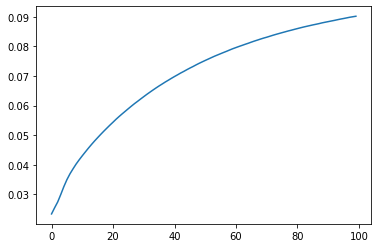

In [24]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings for the simulator

In [15]:
biases, embeddings = model.get_item_representations()

In [28]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(top_songs_meta.assign(j = np.arange(len(top_songs_meta))).itertuples(index=False, name=None)), tag="msd", metadata_header=["artist", "title", "j"])
writer.close()

In [29]:
np.save(DATA_DIR + "tracks", embeddings)

## Sample and save user tastes

In [37]:
track_freq = top_songs[item_index].to_frame().reset_index().rename(columns = {"index": "track_id", "song_id": "freq"})

In [39]:
num_users = 100
num_interests = 3

users = []
for j in tqdm.trange(num_users):
    interests = track_freq.sample(n=num_interests, weights="freq").index.values.tolist()
    
    consume_bias = np.random.uniform(0, 10)
    consume_sharpness = np.power(np.random.uniform(1, 2), np.random.choice([1, -1]))
    
    users.append({
        "user": j,
        "interests": interests,
        "consume_bias": consume_bias,
        "consume_sharpness": consume_sharpness
    })

100%|██████████| 100/100 [00:00<00:00, 358.71it/s]


In [40]:
with open(DATA_DIR + "users.json", "w") as users_file:
    for user in users:
        users_file.write(json.dumps(user) + "\n")

## Visualize embeddings distribution

In [41]:
n = 30
sample_tracks = np.random.choice(np.arange(embeddings.shape[0]), n)

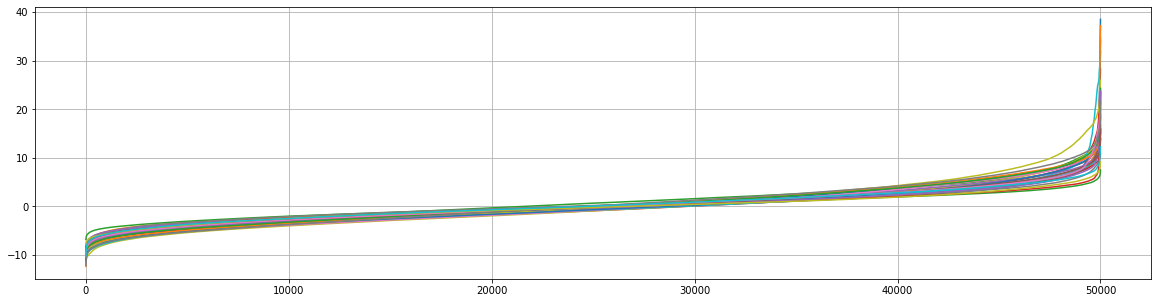

In [42]:
dots = np.dot(embeddings[sample_tracks], embeddings.T)

x = np.arange(embeddings.shape[0])

fig, ax = pl.subplots(figsize=(20, 5))

for j in range(n):
    y = np.sort(dots[j])
    ax.plot(x, y)
    
ax.grid()

pass